# Praktikum 3


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import data...

In [16]:
   
def import_data(separator):
    """ This function is when you put together several datasets,
    but each dataset always starts with a time of 0.
    Input: dataframe that also has a column 't'
    Output: continuous time over all datasets
   """
    def time_norm(data):
        a = list(data.iloc[:]['t'])
        b = list(data.iloc[:]['t'])
        
        for u in range(len(a)-1):
            if a[u]>a[u+1]:
                if b[u]>b[u+1]:
                    offset = a[u]-a[u+1]+1
                    a[u+1] = offset + a[u+1]
                    u += 1
                else:
                    a[u+1] = offset + a[u+1]
                    u += 1
                      
        output = pd.DataFrame({'emg': data.emg, 't': a})
        output.reset_index(inplace = True, drop = True)
        return output
    
    """import data and put weights in one variable and mvc in one variable"""
    column_names = [
      'emg',
      't',  
    ]
    # Creating an empty Dataframe with column names only
    weights_raw = pd.DataFrame(columns=column_names)
    mvc_raw = pd.DataFrame(columns=column_names)
    fatigue_raw = pd.DataFrame(columns=column_names)
    
    # read all mvc, weight, and fatigue files 
    for i in range(3):
        # create string for path
        weights_string = 'Weight' + str(i+1) + '.txt'
        mvc_string = 'MVC' + str(i+1) + '.txt'
        fatigue_string = 'Fatigue' + str(i+1) + '.txt'
        
        weights_raw = pd.concat([weights_raw, pd.read_csv(
            weights_string,
             sep=separator, names=column_names, skiprows= 50,
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
        mvc_raw = pd.concat([mvc_raw, pd.read_csv(
            mvc_string,
             sep=separator, names=column_names, skiprows= 50, 
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
        fatigue_raw = pd.concat([fatigue_raw, pd.read_csv(
            fatigue_string,
             sep=separator, names=column_names, skiprows= 50, 
             skipfooter = 50,
             engine='python'
            )], ignore_index=True)
    # timing needs changing as, the appended data starts from 0 again
    weights = time_norm(weights_raw)
    mvc = time_norm(mvc_raw)
    fatigue = time_norm(fatigue_raw)
    return weights, mvc, fatigue

In [17]:
weights, mvc, fatigue = import_data('\t')

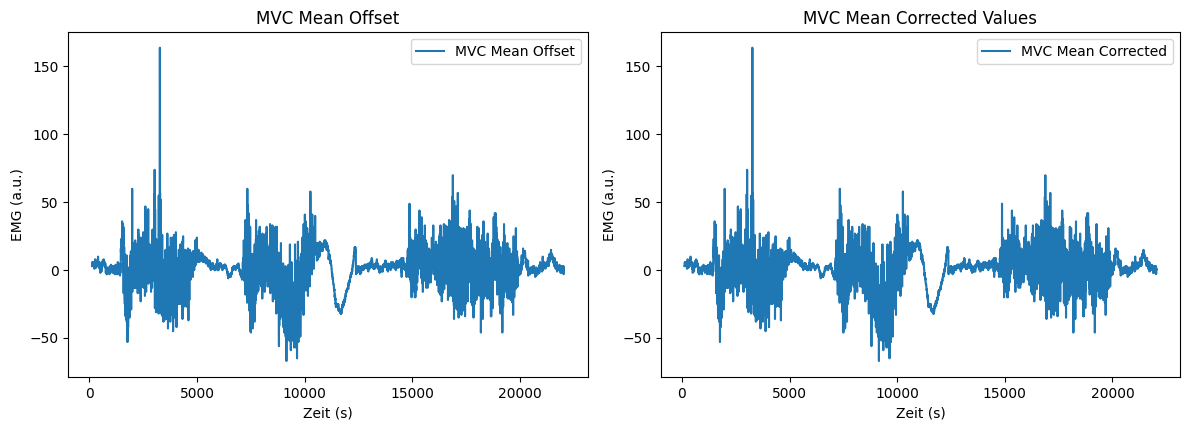

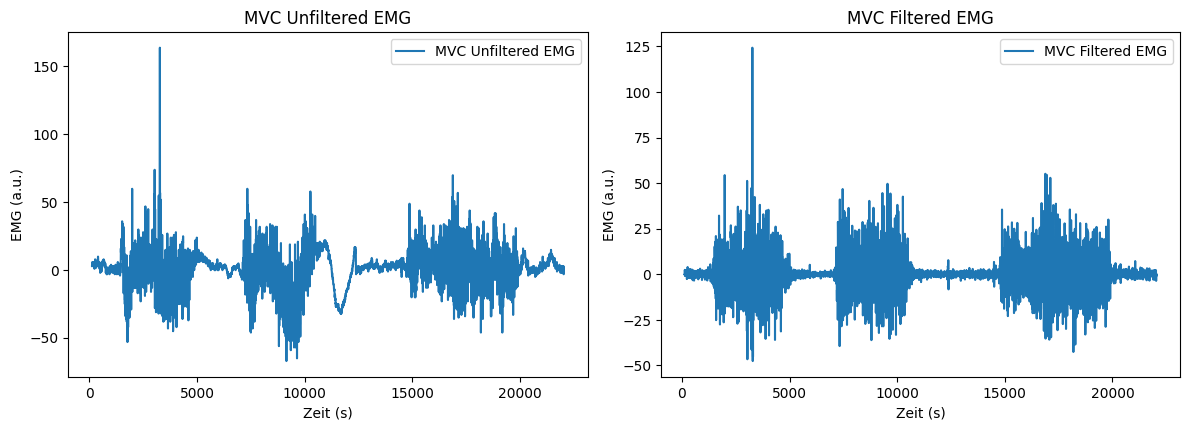

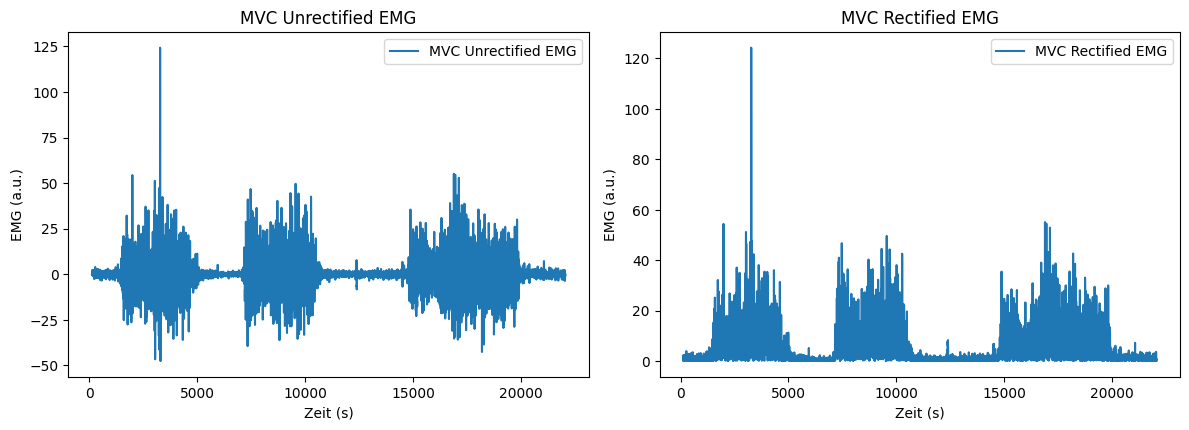

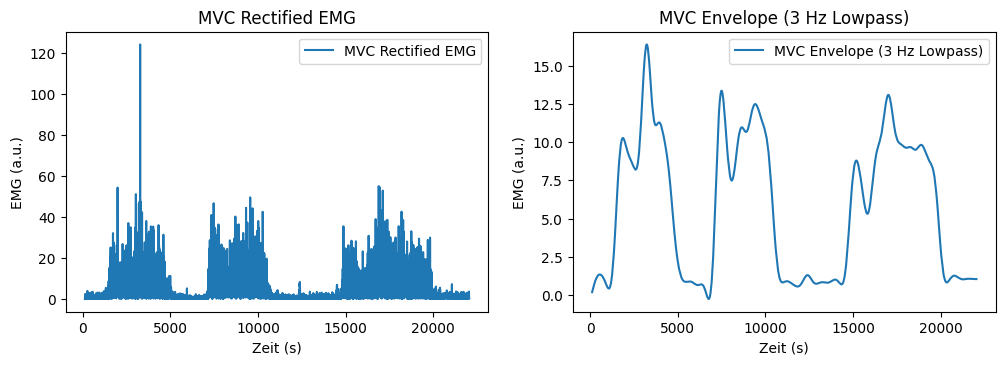

<Figure size 640x480 with 0 Axes>

In [19]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Funktionen zum Einlesen und Normalisieren der Daten
def import_data(files, separator):
    def normalize_time(data):
        times = data['t'].values
        offset = 0
        for i in range(1, len(times)):
            if times[i] < times[i - 1]:
                offset += times[i - 1]
            times[i] += offset
        data['t'] = times
        return data

    all_data = []
    for file in files:
        df = pd.read_csv(file, sep=separator, names=['emg', 't'], skiprows=50, skipfooter=50, engine='python')
        df = normalize_time(df)
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Hoch- und Tiefpassfilter definieren
def butterworth_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low')
    return signal.filtfilt(b, a, data)

# Hauptverarbeitungsschritte
def process_emg_data(data, fs=1000):
    # Offset entfernen
    data['emg'] = data['emg'] - np.mean(data['emg'])

    # Bandpassfiltern (20-450 Hz)
    data['filtered_emg'] = butterworth_filter(data['emg'], 20, 450, fs)

    # Signal gleichrichten (Absolutwert bilden)
    data['rectified_emg'] = np.abs(data['filtered_emg'])

    # Tiefpassfilter auf den Absolutwert anwenden (3 Hz)
    data['envelope'] = lowpass_filter(data['rectified_emg'], 3, fs)

    return data


# MVC Mean Offset und Mean Corrected Values berechnen und plotten
mvc_mean_offset = np.mean(mvc['emg'])
mvc['mean_corrected'] = mvc['emg'] - mvc_mean_offset

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mvc['t'], mvc['emg'], label='MVC Mean Offset')
plt.title('MVC Mean Offset')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(mvc['t'], mvc['mean_corrected'], label='MVC Mean Corrected')
plt.title('MVC Mean Corrected Values')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()

plt.tight_layout()
plt.show()

# MVC Unfiltered und Filtered EMG plotten
mvc_filtered_emg = butterworth_filter(mvc['mean_corrected'], 20, 450, fs=1000)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mvc['t'], mvc['mean_corrected'], label='MVC Unfiltered EMG')
plt.title('MVC Unfiltered EMG')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(mvc['t'], mvc_filtered_emg, label='MVC Filtered EMG')
plt.title('MVC Filtered EMG')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()

plt.tight_layout()
plt.show()

# MVC Unrectified und Rectified EMG plotten
mvc_rectified_emg = np.abs(mvc_filtered_emg)
mvc_envelope = lowpass_filter(mvc_rectified_emg, 3, fs=1000)

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mvc['t'], mvc_filtered_emg, label='MVC Unrectified EMG')
plt.title('MVC Unrectified EMG')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(mvc['t'], mvc_rectified_emg, label='MVC Rectified EMG')
plt.title('MVC Rectified EMG')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(mvc['t'], mvc_rectified_emg, label='MVC Rectified EMG')
plt.title('MVC Rectified EMG')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(mvc['t'], mvc_envelope, label='MVC Envelope (3 Hz Lowpass)')
plt.title('MVC Envelope (3 Hz Lowpass)')
plt.xlabel('Zeit (s)')
plt.ylabel('EMG (a.u.)')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()


#test

2. gemittelte Daten von MVC berechnen und in ein csv datei abspeichern (ohne Berücksichtigung der 1. import data...)

In [20]:
def get_bursts(mvc_emg_filtered, weights_emg_filtered, fatigue_emg_filtered):   
    def get_individual_burst(x):
        def tellme(s):
            print(s)
            plt.title(s, fontsize=16)
            plt.draw()
            
        plt.clf()
        plt.setp(plt.gca(), autoscale_on=True)
        plt.plot(x)
       
        tellme('Click once to start zoom')
        plt.waitforbuttonpress()
        
        while True:
            tellme('Select two corners of zoom, enter/return key to finish')
            pts = plt.ginput(2, timeout=-1)
            if len(pts) < 2:
                break
            (x0, y0), (x1, y1) = pts
            xmin, xmax = sorted([x0, x1])
            ymin, ymax = sorted([y0, y1])
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
          
            
        tellme('Choose start of activity')    
        s = plt.ginput(1)
        tellme('Choose end of activity')   
        e = plt.ginput(1)
        s1 = s[0]
        e1 = e[0]
        start = int(s1[0].astype(int))
        end = int(e1[0].astype(int))
        plt.show()
        
        return start,end
    number_bursts = 3
    mvc_start = np.empty(number_bursts)
    mvc_end = np.empty(number_bursts)
    weights_start = np.empty(number_bursts)
    weights_end = np.empty(number_bursts)
    fatigue_start = np.empty(number_bursts)
    fatigue_end = np.empty(number_bursts)
    for i in range(number_bursts):
        mvc_start[i], mvc_end[i] = get_individual_burst(mvc_emg_filtered)
    for i in range(number_bursts): 
        weights_start[i], weights_end[i] = get_individual_burst(weights_emg_filtered)
    for i in range(number_bursts): 
        fatigue_start[i], fatigue_end[i] = get_individual_burst(fatigue_emg_filtered)  
       
    mvc_start = mvc_start.astype(int)
    mvc_end = mvc_end.astype(int)
    weights_start = weights_start.astype(int)
    weights_end = weights_end.astype(int)
    fatigue_start = fatigue_start.astype(int)
    fatigue_end = fatigue_end.astype(int)
    
    
    return mvc_start, mvc_end, weights_start, weights_end, fatigue_start, fatigue_end